# Nama: Laksmi Dyah Nurlita
# NIM: 21110023
# Kelas: S1SD02-A

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
#library clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/LAKSMI/Online Retail.csv', sep=",", header = 0)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


**EDA**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
#MENCARI PRESENTASE YANG KOSONG
df_null = round(100*(df.isnull().sum())/len(df), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

**DATA PREPROCESSING**

In [ ]:
#Menghapus
df = df.dropna()

In [ ]:
df.shape

(406829, 8)

In [ ]:
#Ubah jadi string
df['CustomerID'] = df.CustomerID.astype(str)

In [ ]:
#Ubah jadi numerik
df['Quantity'] = pd.to_numeric(df['Quantity'], errors = 'coerce')
df['UnitPrice'] = pd.to_numeric(df['UnitPrice'], errors = 'coerce')

#Buat atribut baru
df['Monetary'] = df['Quantity'] * df['UnitPrice']

#Group by 
rfm_m = df.groupby('CustomerID')['Monetary'].sum().reset_index()
rfm_m.head()

,CustomerID,Monetary
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [ ]:
#Buat atribut baru
rfm_f = df.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [ ]:
#Gabung 2 data frame
rfm = pd.merge(rfm_m, rfm_f, on = 'CustomerID', how = 'inner')
rfm.head()

,CustomerID,Monetary,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [ ]:
#Buat atribut 'recency' dengan convert 'invoicedate' ke datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], infer_datetime_format = True)

In [ ]:
#Data terakhir (tanggal terakhir)
maxdate = max(df['InvoiceDate'])
maxdate

Timestamp('2011-12-09 12:50:00')

In [ ]:
#Selisih maxdate dengan invoicedate
df['Diff'] = maxdate - df['InvoiceDate']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Monetary,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [ ]:
#Menghitung transaksi terakhir
rfm_p = df.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [ ]:
#Extract jumlah hari
rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [ ]:
rfm.shape

(4372, 3)

In [ ]:
#Gabung data frame
rfm = pd.merge(rfm, rfm_p, on = 'CustomerID', how = 'inner')
rfm.columns = ['CustomerID', 'Monetary', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Monetary,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


Text(0.5, 0, 'Attributes')

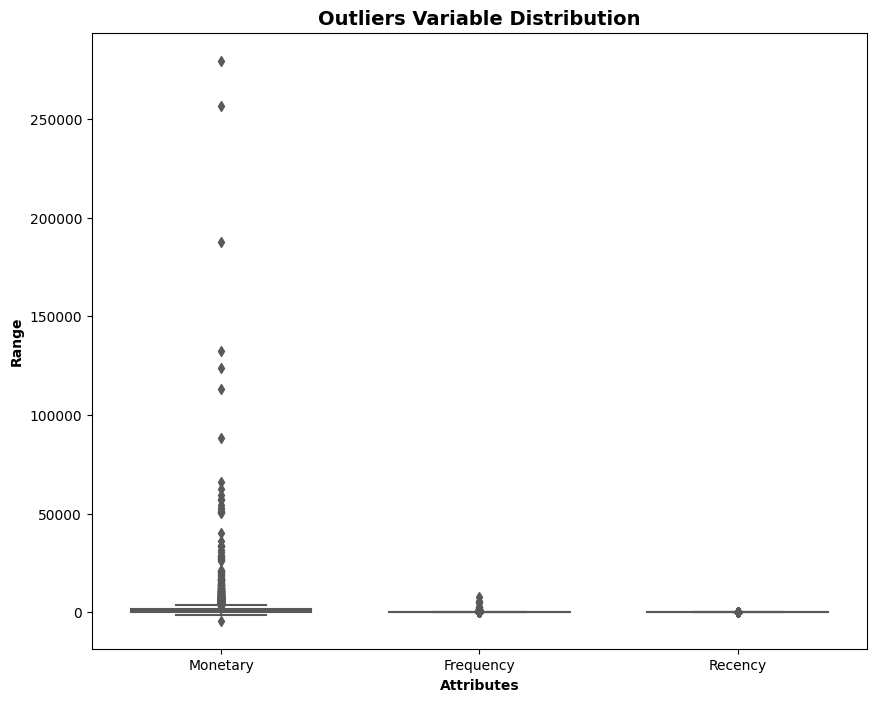

In [ ]:
from matplotlib.projections.polar import PolarTransform
attributes = ['Monetary', 'Frequency', 'Recency']
plt.rcParams['figure.figsize'] = [10, 8]
sns.boxplot(data = rfm[attributes], orient = 'v', palette = 'Set2', whis = 1.5, saturation = 1, width = 0.7)
plt.title('Outliers Variable Distribution', fontsize = 14, fontweight = 'bold')
plt.ylabel('Range', fontweight = 'bold')
plt.xlabel('Attributes', fontweight = 'bold')


Text(0.5, 0, 'Attributes')

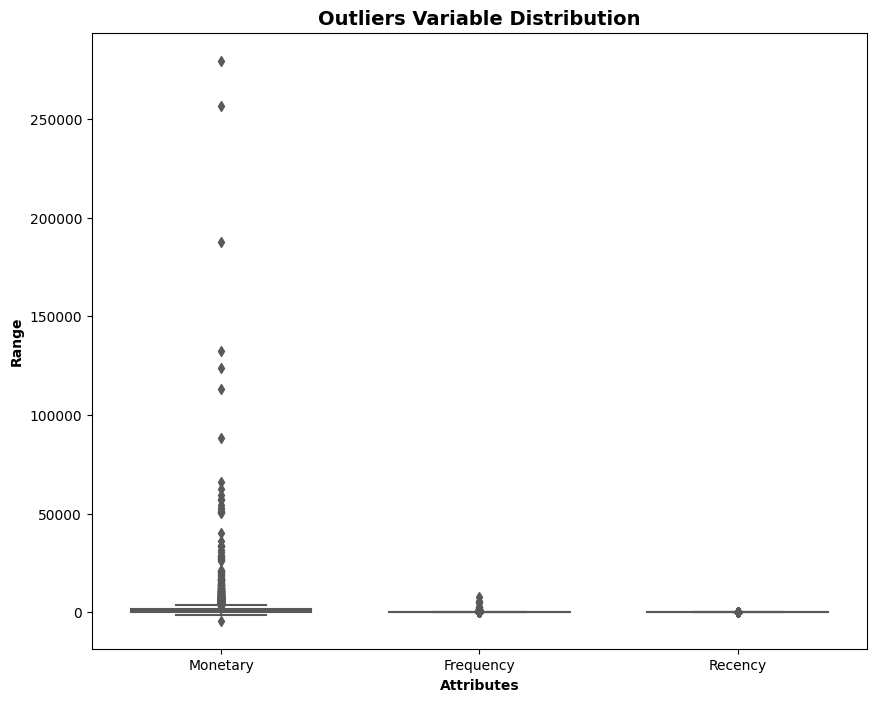

In [ ]:
# Outlier Analysis of Monetary, Frequency and Recency
attributes = ['Monetary','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [ ]:
# Removing (statistical) outliers for Monetary
Q1 = rfm.Monetary.quantile(0.05)
Q3 = rfm.Monetary.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Monetary >= Q1 - 1.5*IQR) & (rfm.Monetary <= Q3 + 1.5*IQR)]
# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]
# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

In [ ]:
#Rescaling atribut
rfm_df = rfm[['Monetary', 'Frequency', 'Recency']]

#instantiate
scaler = StandardScaler()

#fit transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

In [ ]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


In [ ]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=4)

In [ ]:
kmeans.labels_

array([1, 2, 3, ..., 1, 3, 3], dtype=int32)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

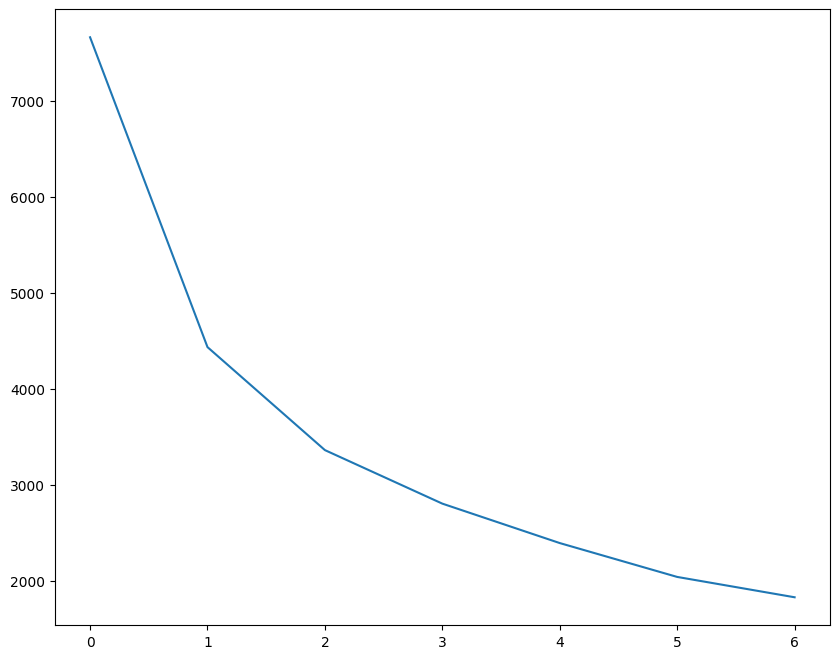

In [ ]:
# Elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

**MODELLING**

In [ ]:
# Silhouette Analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    
    # Initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    cluster_labels = kmeans.labels_
    
    # Silhouette Score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=2, the silhouette score is 0.5415858652525395


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=3, the silhouette score is 0.5084896296141937


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=4, the silhouette score is 0.4777820100216849


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=5, the silhouette score is 0.46464537019783203


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=6, the silhouette score is 0.41713672616001374


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=7, the silhouette score is 0.4181795595993172


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=8, the silhouette score is 0.40790220534014515


In [ ]:
# Final model with k=2
kmeans = KMeans(n_clusters=2, max_iter=50)
kmeans.fit(rfm_df_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=2)

In [ ]:
# Assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Monetary,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,0


<Axes: xlabel='Cluster_Id', ylabel='Monetary'>

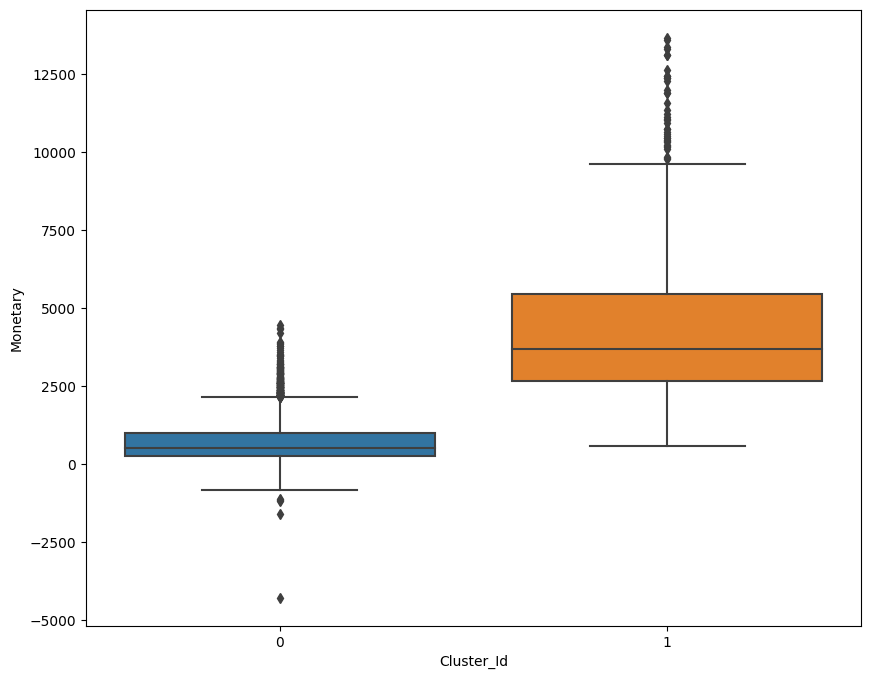

In [ ]:
# Boxplot untuk memvisualisasikan Cluster Id dan Monetary
sns.boxplot(x='Cluster_Id', y='Monetary', data=rfm)

<Axes: xlabel='Cluster_Id', ylabel='Frequency'>

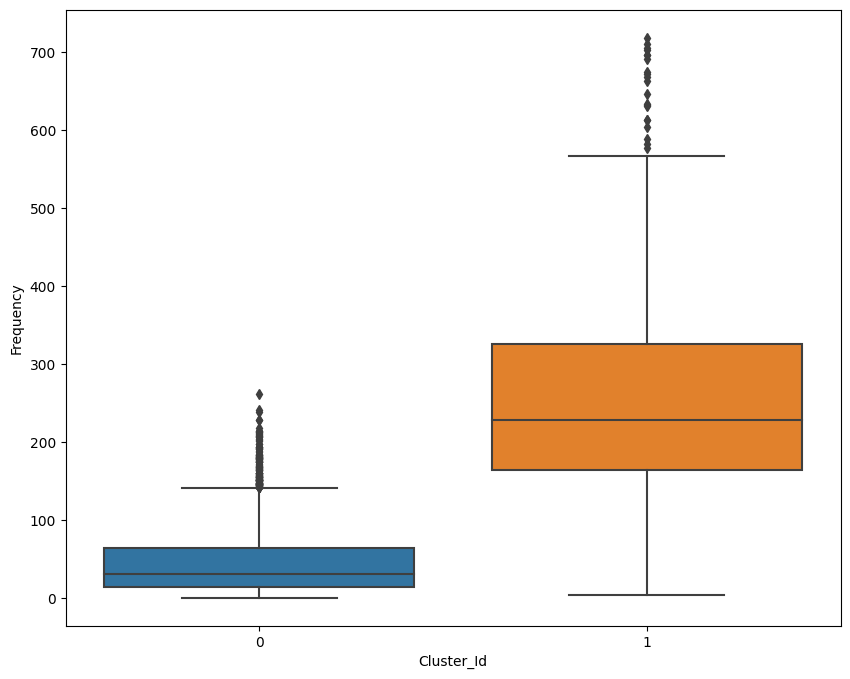

In [ ]:
# Boxplot untuk memvisualisasikan Cluster Id vs Frequency
sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

**DBSCAN (DENSITY-BASED SPATIAL CLUSTERING OF APPLICATIONS WITH NOISE)**

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

buat dataset sejumlah 200 sample (data point) denga setiap data poin memiliki 2 fitur

In [ ]:
#Membuat dataset
X, y = make_blobs(n_samples = 200, n_features = 2, centers = 3, random_state = 42)

In [ ]:
neighb = NearestNeighbors(n_neighbors=2)
nbrs=neighb.fit(X) # fit data
distances,indices=nbrs.kneighbors(X) # mencari nearest neighbours

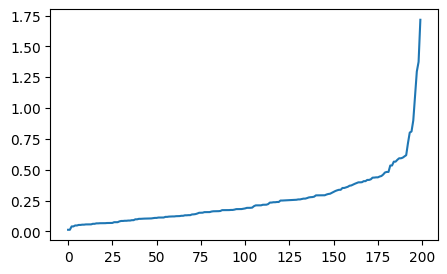

In [ ]:
# Sort and plot the distances results
distances = np.sort(distances, axis = 0) # mengurutkan distances
distances = distances[:, 1] # mengambil kolom kedua
plt.rcParams['figure.figsize'] = (5,3)
plt.plot(distances)
plt.show()

In [ ]:
# Train model DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=4) #karena 2 fitur
dbscan.fit(X)

# label hasil prediksi
labels = dbscan.labels_

In [ ]:
print(y)

[1 0 2 2 2 2 0 2 1 2 1 1 1 1 1 2 0 2 1 2 1 1 2 0 2 0 0 2 0 1 1 1 2 2 0 0 2
 0 2 0 1 0 2 1 2 1 1 2 1 0 2 0 2 0 0 0 2 1 0 1 2 0 2 2 2 2 0 0 2 0 0 2 0 1
 0 1 1 0 1 0 0 1 1 2 2 2 2 0 1 2 1 0 0 0 1 2 0 1 1 0 2 2 0 2 0 1 2 1 1 2 1
 1 0 2 0 2 2 0 0 0 2 1 0 2 2 1 0 0 1 0 1 2 0 2 2 1 1 1 0 1 0 0 2 1 1 0 1 2
 2 1 0 2 1 2 1 2 2 0 1 1 0 1 1 2 0 1 1 0 2 1 2 0 1 2 0 1 0 0 0 1 0 1 2 2 2
 0 1 1 1 0 0 1 2 2 0 2 0 0 1 1]


In [ ]:
print(labels)

[ 0 -1  1  1  1  1  2  1 -1  1  0  0  0  0  0  1  2  1  0  1  0  0  1  2
  1  2  2  1  2  0  0 -1 -1  1  2  2  1  2  1  2  0  2  1  0 -1  0  0  1
  0  2  1  2  1  2  2  2 -1  0  2  0  1  2  1  1  1  1  2  2  1  2  2  1
  2  0  2  0  0  2 -1  2  2  0 -1  1  1  1  1  2  0  1  0  2  2  2  0  1
  2  0  0  2  1  1  2  1  2  0  1  0  0  1  0  0  2  1  2  1  1  2  2  2
  1  0  2  1  1  0  2  2  0  2  0  1  2  1  1  0  0  0  2  0  2  2 -1  0
  0  2  0  1  1  0  2  1 -1  1  0  1  1  2  0  0  2  0  0  1  2  0  0  2
  1  0  1  2  0  1  2  0 -1  2  2  0  2  0  1  1  1  2  0  0  0  2  2  0
  1  1  2  1  2  2  0  0]


-1 = outlier

In [ ]:
non_outlier = np.count_nonzero(labels != -1)
outlier_unknown = np.count_nonzero(labels == -1)

print(f"Number of values not equal to -1: {non_outlier}")
print(f"Number of values equal to -1: {outlier_unknown}")

Number of values not equal to -1: 189
Number of values equal to -1: 11


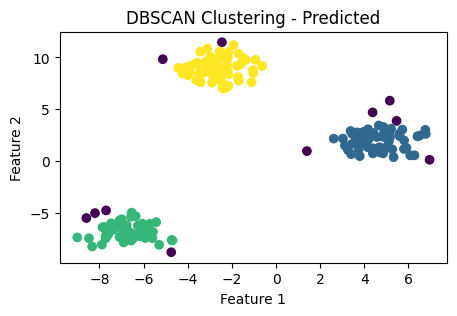

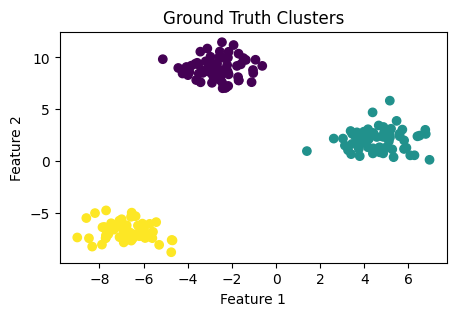

In [ ]:
# Plot cluster hasil prediksi
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.title('DBSCAN Clustering - Predicted')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Plot cluster asli
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.title('Ground Truth Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [ ]:
# Evaluasimenggunakan silhouette score
silhouette = silhouette_score(X, labels)

print("Silhouette Coefficient:", silhouette)

Silhouette Coefficient: 0.7562389996590693




*   Skor mendekati +1 --> sampel terkelompok dengan baik dan jauh dari sampel di kelompok lain
*   Skor mendekati 0 --> cluster yang tumpang tindih


*   Skor mendekati -1 --> sampel salah dikelompokkan atau mungkin termasuk dalam kelompok yang berbeda



